In [62]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Where should Lawton retire?

In [74]:
income = Table.read_table('data/us-median-income-2023.csv')
income

Geographic Area Name,Median income estimate
Alabama,33108
Alaska,43069
Arizona,39900
Arkansas,32294
California,41901
Colorado,46958
Connecticut,46415
Delaware,41678
District of Columbia,70144
Florida,36270


In [75]:
income = income.take(np.arange(52, income.num_rows))

In [76]:
income.where(0, are.containing('Fresno'))

Geographic Area Name,Median income estimate
"Centerville CDP (Fresno County), California",-
"Fresno city, California",33148
"Fresno CDP, Ohio",16488
"Fresno CDP, Texas",42540
"Los Fresnos city, Texas",33168
"Los Fresnos CDP, Texas",45057


In [77]:
income.where(0, are.containing('Clovis'))

Geographic Area Name,Median income estimate
"Clovis city, California",47696
"Clovis city, New Mexico",31392


In [78]:
def fix(x):
    try:
        return int(x)
    except:
        return -1

income = income.with_column('Median income estimate', income.apply(fix, 1))

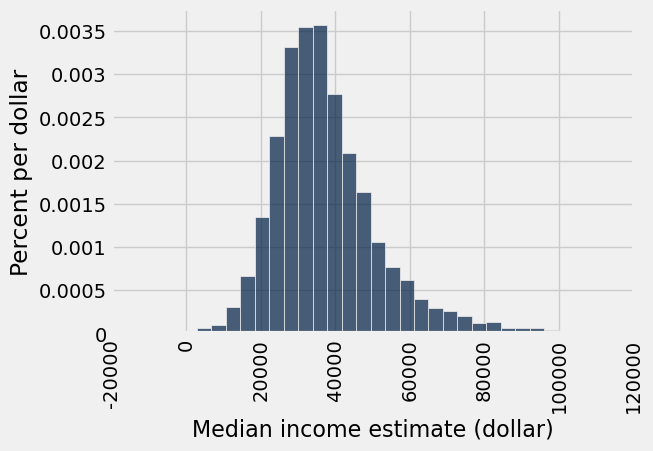

In [79]:
income.where(1, are.between_or_equal_to(0, 100000)).hist(1, bins=25, unit='dollar')

In [80]:
tjs = Table.read_table('data/trader-joes-locations-2025.csv')
tjs

City
"Birmingham, AL"
"Hoover, AL"
"Huntsville, AL"
"Chandler, AZ"
"Gilbert, AZ"
"Glendale, AZ"
"Mesa, AZ"
"Oro Valley, AZ"
"Phoenix, AZ"
"Prescott, AZ"


In [81]:
'Fresno, CA'.split(',')

['Fresno', ' CA']

In [82]:
'Fresno, CA'.split(',')[0]

'Fresno'

In [83]:
'Fresno, CA'.split(',')[1]

' CA'

In [84]:
'Fresno, CA'.split(',')[1].strip()

'CA'

In [85]:
def get_city(s):
    return s.split(',')[0]

def get_state_abbrev(s):
    return s.split(',')[1].strip()

In [86]:
state_abbrevs = Table.read_table('data/state-abbreviations.csv')
state_abbrevs

Name,Abbreviation
Alabama,AL
Alaska,AK
American Samoa,AS
Arizona,AZ
Arkansas,AR
California,CA
Colorado,CO
Connecticut,CT
Delaware,DE
District of Columbia,DC


In [87]:
def get_state(s):
    state_abbrev = get_state_abbrev(s)
    return state_abbrevs.where(1, state_abbrev).row(0).item(0)

In [88]:
tjs

City
"Birmingham, AL"
"Hoover, AL"
"Huntsville, AL"
"Chandler, AZ"
"Gilbert, AZ"
"Glendale, AZ"
"Mesa, AZ"
"Oro Valley, AZ"
"Phoenix, AZ"
"Prescott, AZ"


In [89]:
tjs = tjs.with_columns(
    'City', tjs.apply(get_city, 0),
    'State', tjs.apply(get_state, 0)
)
tjs

City,State
Birmingham,Alabama
Hoover,Alabama
Huntsville,Alabama
Chandler,Arizona
Gilbert,Arizona
Glendale,Arizona
Mesa,Arizona
Oro Valley,Arizona
Phoenix,Arizona
Prescott,Arizona


In [90]:
income

Geographic Area Name,Median income estimate
"Abanda CDP, Alabama",34911
"Abbeville city, Alabama",21678
"Adamsville city, Alabama",31873
"Addison town, Alabama",30833
"Akron town, Alabama",22500
"Alabaster city, Alabama",43502
"Albertville city, Alabama",29150
"Alexander City city, Alabama",27114
"Alexandria CDP, Alabama",41685
"Aliceville city, Alabama",18750


In [91]:
income.where(0, are.containing('Phoenix')).where(0, are.containing('Arizona'))

Geographic Area Name,Median income estimate
"Phoenix city, Arizona",40786


In [127]:
def get_median_income(city, state):
    results = income.where(0, are.containing(city)).where(0, are.containing(state))
    if results.num_rows > 0:
        return results.column(1).item(0)
    else:
        return -1

In [129]:
tjs_with_income = tjs.with_column('Median Income', tjs.apply(get_median_income, 0, 1))
tjs_with_income

City,State,Median Income
Birmingham,Alabama,28054
Hoover,Alabama,53074
Huntsville,Alabama,38349
Chandler,Arizona,52580
Gilbert,Arizona,55389
Glendale,Arizona,36441
Mesa,Arizona,24573
Oro Valley,Arizona,50816
Phoenix,Arizona,40786
Prescott,Arizona,38235


In [131]:
tjs_with_income.where('Median Income', are.above(0)).sort('Median Income').show(25)

City,State,Median Income
Fairfield,Connecticut,4383
State College,Pennsylvania,10085
East Lansing,Michigan,12408
Newark,Delaware,17087
College Park,Maryland,17695
Williamsburg,Virginia,23543
Mesa,Arizona,24573
Kalamazoo,Michigan,24899
Gainesville,Florida,25603
Corvallis,Oregon,26868


In [ ]:
# The first two are "cities" containing only college students

# Mendel

In [3]:
null_proportions = make_array(0.75, 0.25)
null_proportion_purple = null_proportions.item(0)

sample_proportions(929, null_proportions)

array([ 0.73089343,  0.26910657])

In [8]:
def one_simulated_distance():
    sample_proportion_purple = sample_proportions(929, null_proportions).item(0)
    return abs(sample_proportion_purple - null_proportion_purple)

In [9]:
one_simulated_distance()

0.006727664155005364

In [10]:
observed_distance = (705 / 929) - 0.75
observed_distance

0.008880516684607098

In [12]:
repetitions = 1000
distances = make_array()
for i in np.arange(repetitions):
    distances = np.append(distances, one_simulated_distance())

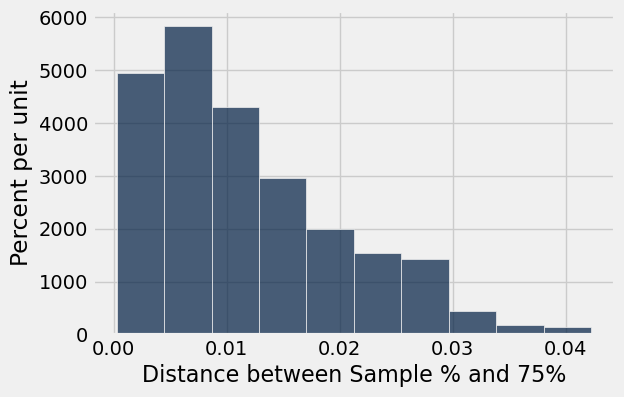

In [13]:
Table().with_column(
    'Distance between Sample % and 75%', distances
).hist()

In [14]:
np.count_nonzero(distances >= observed_distance) / repetitions

0.547

# Cereal

In [15]:
cereal = Table.read_table('data/cereal.csv')
cereal

name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
100% Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33,68.403
100% Natural Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1,33.9837
All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33,59.4255
All-Bran with Extra Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.5,93.7049
Almond Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75,34.3848
Apple Cinnamon Cheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1,0.75,29.5095
Apple Jacks,K,C,110,2,0,125,1,11,14,30,25,2,1,1,33.1741
Basic 4,G,C,130,3,2,210,2,18,8,100,25,3,1.33,0.75,37.0386
Bran Chex,R,C,90,2,1,200,4,15,6,125,25,1,1,0.67,49.1203
Bran Flakes,P,C,90,3,0,210,5,13,5,190,25,3,1,0.67,53.3138


In [16]:
cereal.select('shelf', 'sugars').group('shelf', np.average)

shelf,sugars average
1,4.8
2,9.61905
3,6.52778


In [17]:
cereal.with_column(
    'Shuffled Label', cereal.sample(with_replacement=False).column('shelf')
)

name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,Shuffled Label
100% Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33,68.403,2
100% Natural Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1,33.9837,3
All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33,59.4255,3
All-Bran with Extra Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.5,93.7049,2
Almond Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75,34.3848,3
Apple Cinnamon Cheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1,0.75,29.5095,2
Apple Jacks,K,C,110,2,0,125,1,11,14,30,25,2,1,1,33.1741,1
Basic 4,G,C,130,3,2,210,2,18,8,100,25,3,1.33,0.75,37.0386,3
Bran Chex,R,C,90,2,1,200,4,15,6,125,25,1,1,0.67,49.1203,3
Bran Flakes,P,C,90,3,0,210,5,13,5,190,25,3,1,0.67,53.3138,2


In [18]:
def one_sample_average():
    return cereal.with_column(
        'Shuffled Label', cereal.sample(with_replacement=False).column('shelf')
    ).where('Shuffled Label', 2).column('sugars').mean()

simulations = 1000
sample_averages = make_array()
for i in np.arange(simulations):
    sample_averages = np.append(sample_averages, one_sample_average())

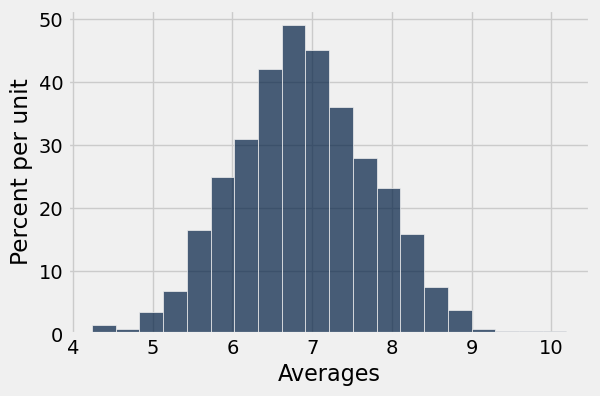

In [19]:
Table().with_column('Averages', sample_averages).hist(0, bins=20)

In [20]:
np.count_nonzero(sample_averages >= 9.61905) / len(sample_averages)

0.001

# Titanic

In [23]:
titanic = Table.read_table('data/titanic.csv').where('Age', are.above_or_equal_to(0))
titanic

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,nan,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,nan,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,nan,S
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,nan,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,nan,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,nan,C
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7,G6,S


In [25]:
# take a size 100 sample without replacement; pretend that's all we get
sample = titanic.sample(100, with_replacement=False)

# make a function to generate a resample from your original sample and give back the avg. age
def one_bootstrap_average():
    resample = sample.sample()
    return resample.column('Age').mean()

In [26]:
# Generate averages from 5000 bootstrap samples
num_repetitions = 5000
bstrap_means = make_array()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_average())

In [27]:
# Get a 95% confidence interval for the average age
percentile(2.5, bstrap_means), percentile(97.5, bstrap_means)

(25.77, 31.219999999999999)

In [28]:
# Actual average age for every passenger
titanic.column('Age').mean()

29.69911764705882

# Father & Son

In [35]:
sons_heights = Table.read_table('data/sons_heights.csv').select('father', 'son')
sons_heights

father,son
78.5,73.2
75.5,73.5
75,71
75,70.5
75,72
74,76.5
74,74
73,71
73,68
73,71


In [36]:
def standard_units(arr):
    """ Converts an array to standard units (a.k.a. z-scores) """
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    """ Computes correlation: t is a table, and x and y are column names """
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    """ Computes the slope of the regression line, like correlation above """
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    """ Computes the intercept of the regression line, like slope above """
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates (predictions) at all the x values"""
    m = slope(t, x, y)
    b = intercept(t, x, y)
    return m*t.column(x) + b

0.50072475554943707

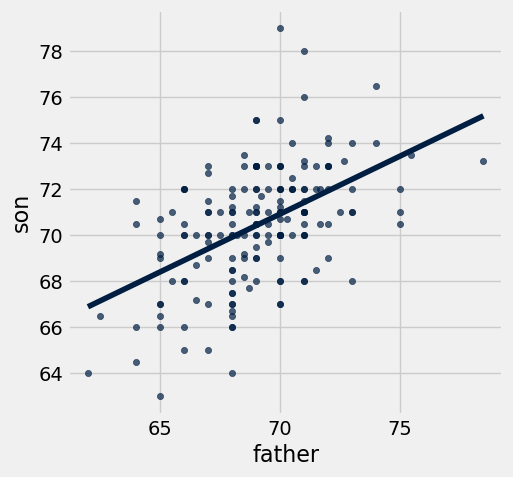

In [37]:
sons_heights.scatter('father', 'son', fit_line=True)
correlation(sons_heights, 'father', 'son')

In [46]:
# could use fitted_values, but this is more educational
m = slope(sons_heights, 'father', 'son')
b = intercept(sons_heights, 'father', 'son')
predictions = m*sons_heights.column('father') + b
sons_heights = sons_heights.with_column('predicted son height', predictions)
sons_heights

father,son,predicted son height
78.5,73.2,75.1815
75.5,73.5,73.6732
75,71,73.4218
75,70.5,73.4218
75,72,73.4218
74,76.5,72.919
74,74,72.919
73,71,72.4162
73,68,72.4162
73,71,72.4162


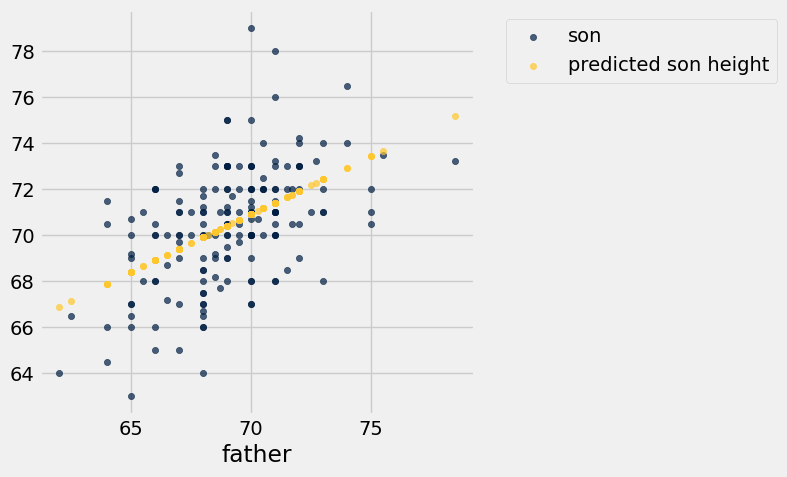

In [39]:
sons_heights.scatter('father')

In [40]:
errors = sons_heights.column('son') - sons_heights.column('predicted son height')
sons_heights.with_column('error', errors)

father,son,predicted son height,error
78.5,73.2,75.1815,-1.98154
75.5,73.5,73.6732,-0.173169
75,71,73.4218,-2.42177
75,70.5,73.4218,-2.92177
75,72,73.4218,-1.42177
74,76.5,72.919,3.58102
74,74,72.919,1.08102
73,71,72.4162,-1.41619
73,68,72.4162,-4.41619
73,71,72.4162,-1.41619


In [43]:
mse = np.mean(errors ** 2)
rmse = mse ** 0.5
rmse

2.2072170474409565

In [48]:
# regression esimates for slope & height
m, b

(0.50279044119141691, 35.712490894054319)

In [49]:
def rmse_son_height(m, b):
    x = sons_heights.column('father')
    y = sons_heights.column('son')
    predictions = m*x + b
    errors = y - predictions
    return np.mean(errors ** 2) ** 0.5

In [50]:
minimize(rmse_son_height, smooth=True)

array([  0.50278486,  35.71287682])

In [51]:
repetitions = 2500

# create 2500 boostrap samples, find the slopes, and save them all 
slopes = make_array()
for i in np.arange(repetitions):
    bootstrap_sample = sons_heights.sample()
    bootstrap_slope = slope(bootstrap_sample, 'father', 'son')
    slopes = np.append(slopes, bootstrap_slope)

# find the endpoints of the 95% confidence interval for the true slope
left = percentile(2.5, slopes)
right = percentile(97.5, slopes)

In [52]:
left, right

(0.37647440416814926, 0.63918409369840934)

# Classification

In [53]:
patients = Table.read_table('data/breast-cancer.csv').drop('ID')
patients.sample(10)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
3,1,1,1,2,1,1,1,1,0
2,1,1,1,2,1,2,1,1,0
4,1,1,1,3,1,2,2,1,0
5,2,2,2,2,1,2,2,1,0
4,1,1,2,2,1,2,1,1,0
3,1,2,1,2,1,2,1,1,0
10,6,6,2,4,10,9,7,1,1
4,5,5,10,4,10,7,5,8,1
3,1,1,1,2,2,7,1,1,0
6,10,10,2,8,10,7,3,3,1


In [57]:
patients.num_rows

683

In [58]:
683 / 2

341.5

In [59]:
shuffled_patients = patients.sample(683, with_replacement=False)
training_set = shuffled_patients.take(np.arange(342))
test_set = shuffled_patients.take(np.arange(342, 683))

In [60]:
def distance(point1, point2):
    return np.sum((point1 - point2) ** 2) ** 0.5

def all_distances(training, new_row):
    '''Returns an array of distances between each point in the training set
    and the new point (which is an row of attributes)'''
    attributes = training.drop('Class')

    # You can make functions inside other functions! They can use outer variables!
    def distance_from_new_row(row):
        return distance(np.array(new_row), np.array(row))
    
    return attributes.apply(distance_from_new_row)

def nearest(training, new_point, k):
    '''Returns a table of the k rows (with distances attached)
    having the smallest distances from the new_point'''
    distances_to_new_point = all_distances(training, new_point)
    with_dists = training.with_column('Distance', distances_to_new_point)
    sorted_by_distance = with_dists.sort('Distance')
    nearest_neighbors_table = sorted_by_distance.take(np.arange(k))
    return nearest_neighbors_table

def majority(nearest_neighbors_table):
    ones = nearest_neighbors_table.where('Class', are.equal_to(1)).num_rows
    zeros = nearest_neighbors_table.where('Class', are.equal_to(0)).num_rows
    
    if ones > zeros:
        return 1
    else:
        return 0

def knn(training, new_point, k):
    nearest_neighbors_table = nearest(training, new_point, k)
    return majority(nearest_neighbors_table)

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')

    def classify_test_row(row):
        return knn(training, row, k)

    predicted_classes = test_attributes.apply(classify_test_row)
    return np.count_nonzero(predicted_classes == test.column('Class')) / test.num_rows

In [61]:
evaluate_accuracy(training_set, test_set, 5)

0.9706744868035191

# Minnesota Coronary Experiment

In [2]:
summary = Table(['Age', 'Condition', 'Total', 'Deaths', 'CHD Deaths']).with_rows([
    ['0-34',  'Diet',    1367, 3, 0],
    ['35-44', 'Diet',    728, 3, 0],
    ['45-54', 'Diet',    767, 14, 4],
    ['55-64', 'Diet',    870, 35, 7],
    ['65+',   'Diet',    953, 190, 42],
    ['0-34',  'Control', 1337, 7, 1],
    ['35-44', 'Control', 731, 4, 1],
    ['45-54', 'Control', 816, 16, 4],
    ['55-64', 'Control', 896, 33, 12],
    ['65+',   'Control', 958, 162, 34],   
])
summary

Age,Condition,Total,Deaths,CHD Deaths
0-34,Diet,1367,3,0
35-44,Diet,728,3,0
45-54,Diet,767,14,4
55-64,Diet,870,35,7
65+,Diet,953,190,42
0-34,Control,1337,7,1
35-44,Control,731,4,1
45-54,Control,816,16,4
55-64,Control,896,33,12
65+,Control,958,162,34


In [4]:
subjects = Table(['Age', 'Condition', 'Participated', 'Died'])
for row in summary.rows:
    i = np.arange(0, row.item('Total'))
    t = Table().with_columns('Died', i < row.item('Deaths'))
    t.append_column('Age', row.item('Age'))
    t.append_column('Condition', row.item('Condition'))
    t.append_column('Participated', True)
    subjects.append(t)

subjects.sample(10)

Age,Condition,Participated,Died
55-64,Control,True,False
55-64,Diet,True,False
55-64,Diet,True,False
0-34,Diet,True,False
55-64,Control,True,False
35-44,Control,True,False
45-54,Diet,True,False
65+,Control,True,False
55-64,Control,True,False
65+,Diet,True,False


In [5]:
subjects.group(['Age', 'Condition'], sum)

Age,Condition,Participated sum,Died sum
0-34,Control,1337,7
0-34,Diet,1367,3
35-44,Control,731,4
35-44,Diet,728,3
45-54,Control,816,16
45-54,Diet,767,14
55-64,Control,896,33
55-64,Diet,870,35
65+,Control,958,162
65+,Diet,953,190


In [16]:
oldest = subjects.where('Age', '65+')
oldest.group('Condition', sum)

Condition,Age sum,Participated sum,Died sum
Control,,958,162
Diet,,953,190


In [17]:
(190/953) - (162/958)  # the death (hazard) rate was a bit *higher* for the diet group!

0.030268112783058437

In [ ]:
# Null hypothesis: the difference in hazard rates was the same for the control group and diet group
# Simulated value: absolute difference in hazard rate for control/diet

In [18]:
def hazard_rate(counts):
    return counts.item('Died sum') / counts.item('Participated sum')

def rate_difference(t):
    counts = t.drop('Age').group('Condition', sum)
    return abs(hazard_rate(counts.row(1)) - hazard_rate(counts.row(0)))

rate_difference(subjects) # barely any difference for the entire population

0.0054393439270044933

In [19]:
rate_difference(subjects.where('Age', '0-34'))

0.0030410154080667343

In [20]:
rate_difference(subjects.where('Age', '65+'))

0.030268112783058437

In [23]:
def test(t):
    observed = rate_difference(t)
    repetitions = 200

    stats = make_array()
    for i in np.arange(repetitions):
        # permutation test: shuffle who died and check the rate difference
        simulated_results = t.select('Died').sample().column('Died')
        simulated_outcomes = t.with_column('Died', simulated_results)
        simulated_stat = rate_difference(simulated_outcomes)
        stats = np.append(stats, simulated_stat)

    # Find the empirical P-value:
    p = np.count_nonzero(stats >= observed) / repetitions
    
    print('  Observed absolute difference in hazard rates:', observed)
    print('  P-value:', p)

test(subjects)

  Observed absolute difference in hazard rates: 0.005439343927
  P-value: 0.19


In [24]:
for age in subjects.group('Age').column('Age'):
    print('Ages', age)
    test(subjects.where('Age', age))

Ages 0-34
  Observed absolute difference in hazard rates: 0.00304101540807
  P-value: 0.18
Ages 35-44
  Observed absolute difference in hazard rates: 0.00135107710347
  P-value: 0.785
Ages 45-54
  Observed absolute difference in hazard rates: 0.00135490963008
  P-value: 0.855
Ages 55-64
  Observed absolute difference in hazard rates: 0.00339952791461
  P-value: 0.675
Ages 65+
  Observed absolute difference in hazard rates: 0.0302681127831
  P-value: 0.07


# Estimating Exam Scores

In [7]:
scores = Table.read_table('data/scores.csv')
scores

Midterm 1,Midterm 2,Mentored
28,20,False
28.5,35,False
23.5,13.5,False
24.5,22.5,True
28.5,35.5,True
22.5,28,True
24,22.5,False
29,36,True
19.5,20,False
19.5,20,True


In [8]:
scores.drop(2) # let's forget about column 2

Midterm 1,Midterm 2
28,20
28.5,35
23.5,13.5
24.5,22.5
28.5,35.5
22.5,28
24,22.5
29,36
19.5,20
19.5,20


In [9]:
mt1 = scores.column('Midterm 1')
mt2 = scores.column('Midterm 2')
print('Midterm 1 avg:', np.average(mt1), 'std dev:', np.std(mt1))
print('Midterm 2 avg:', np.average(mt2), 'std dev:', np.std(mt2))

Midterm 1 avg: 28.1282477341 std dev: 6.97676731201
Midterm 2 avg: 31.0634441088 std dev: 11.4436677135


## Option 1: use other midterm score

In [10]:
mt1_actual = 21
mt2_estimate_1 = mt1_actual / 40 * 50
mt2_estimate_1

26.25

In [11]:
mt2_estimate_1 - np.average(mt2)

-4.8134441087613276

In [12]:
(mt2_estimate_1 - np.average(mt2)) / np.std(mt2)

-0.42062075108103802

In [13]:
(mt1_actual - np.average(mt1)) / np.std(mt1)
# The z-scores were different! Is this really fair?

-1.0217121218687693

## Option 2: z-score

In [14]:
mt1_actual = 21
mt1_z = (mt1_actual - np.average(mt1)) / np.std(mt1)
mt2_estimate_2 = np.average(mt2) + mt1_z * np.std(mt2)
mt2_estimate_2

19.371310087271372

In [15]:
mt2_estimate_2 - np.average(mt2)

-11.692134021489956

In [16]:
(mt2_estimate_2 - np.average(mt2)) / np.std(mt2)

-1.0217121218687693

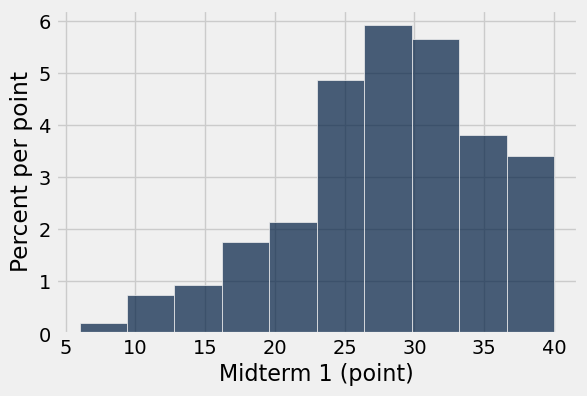

In [17]:
scores.hist('Midterm 1', unit='point')

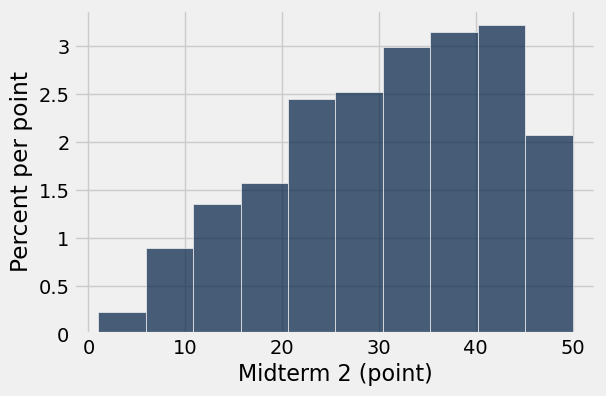

In [18]:
scores.hist('Midterm 2', unit='point')
# The distributions were different! Is this really fair?

## Option 3: percentile

In [19]:
mt1_actual = 21
mt1_percentile = sum(mt1 <= mt1_actual) / len(mt1) * 100
mt1_percentile

15.589123867069487

In [20]:
percentile(mt1_percentile, mt1)

21.0

In [21]:
percentile(mt1_percentile, mt2)

18.0

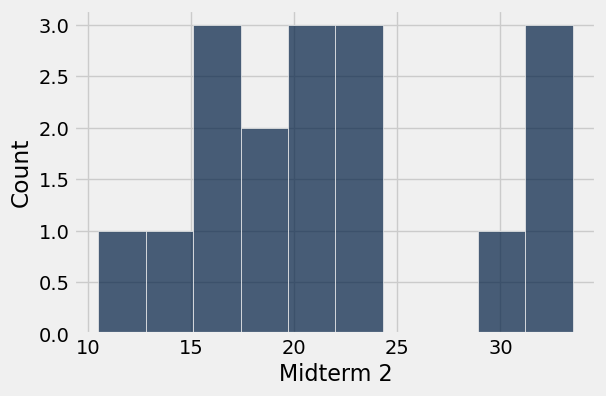

In [22]:
scores.where('Midterm 1', 21).hist('Midterm 2', normed=False)
# But many students with John's Midterm 1 score did completely differently on Midterm 2!
# Maybe we should be doing some kind of prediction?

## Option 4: linear regression

In [23]:
def standard_units(arr):
    """Converts an array to standard units """
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    """Computes correlation: t is a table, and x and y are column names """
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    """Computes the slope of the regression line, like correlation above """
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    """Computes the intercept of the regression line, like slope above """
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates (predictions) at all the x values"""
    m = slope(t, x, y)
    b = intercept(t, x, y)
    return m*t.column(x) + b

In [24]:
r = correlation(scores, 'Midterm 1', 'Midterm 2')
r

0.80256275814864186

In [25]:
mt1_actual = 21
mt1_z = (mt1_actual - np.average(mt1)) / np.std(mt1)
mt2_estimate_2 = np.average(mt2) + mt1_z * r * np.std(mt2)
mt2_estimate_2

21.679772779830778

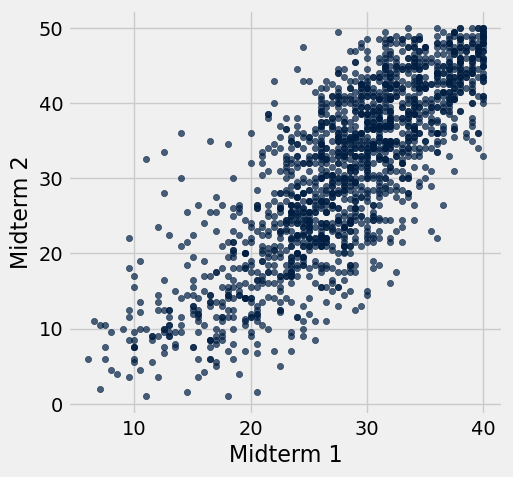

In [26]:
scores.scatter('Midterm 1', 'Midterm 2')

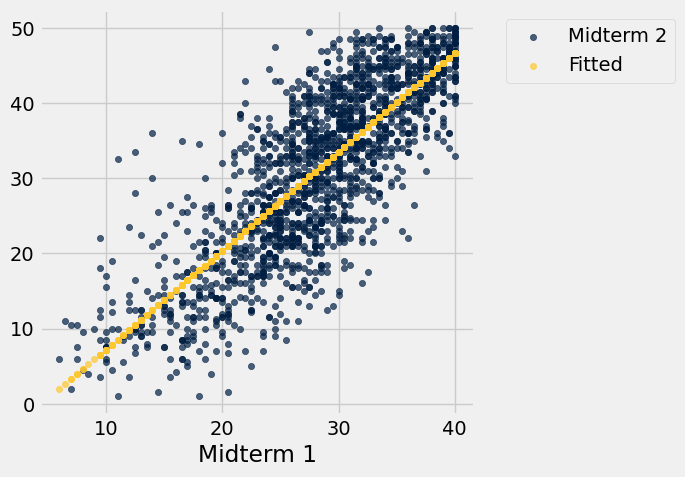

In [27]:
a = slope(scores, 'Midterm 1', 'Midterm 2')
b = intercept(scores, 'Midterm 1', 'Midterm 2')
scores.drop(2).with_column('Fitted', a * mt1 + b ).scatter('Midterm 1')

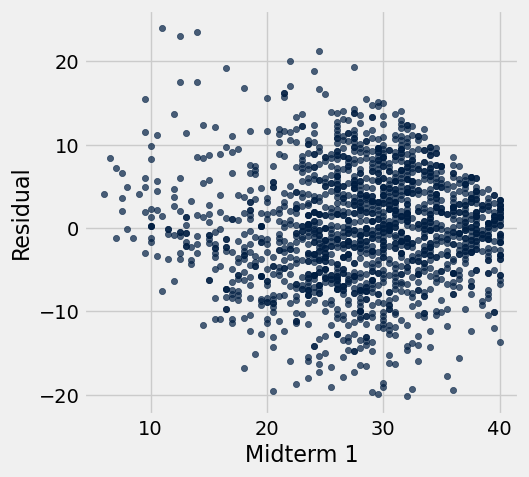

In [28]:
scores.with_column('Residual', mt2 - (a * mt1 + b)).scatter('Midterm 1', 'Residual')

In [ ]:
# ^ looks good for low scores, but underestimating high scores--implies non-linearity

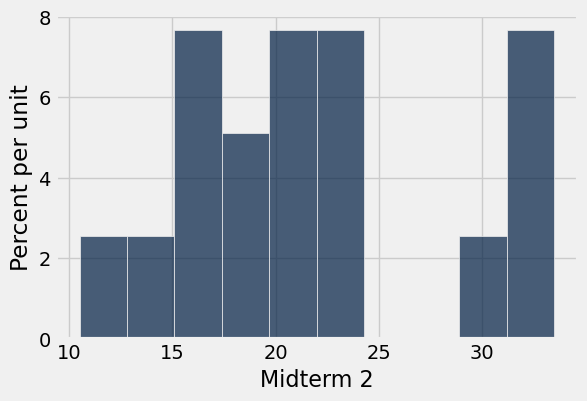

In [29]:
scores.where("Midterm 1", mt1_actual).hist('Midterm 2')

## Option 4.5: nearest neighbors for prediction

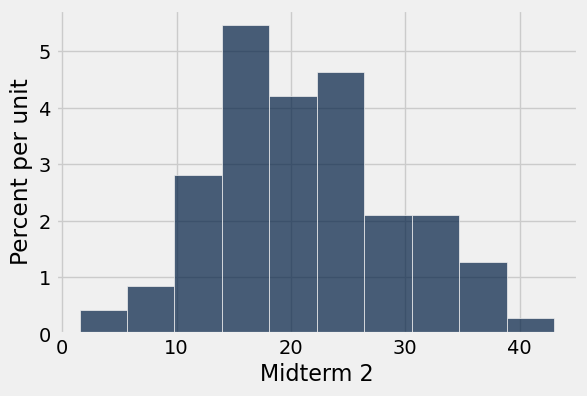

In [30]:
scores.where("Midterm 1", are.between_or_equal_to(mt1_actual-2, mt1_actual+2)).hist('Midterm 2')

In [31]:
def avg_mt2(mt1):
    near = scores.where("Midterm 1", are.between_or_equal_to(mt1-2, mt1+2))
    return near.column("Midterm 2").mean()

avg_mt2(mt1_actual)

21.156976744186046

In [32]:
mt2_avg = scores.apply(avg_mt2, 'Midterm 1')

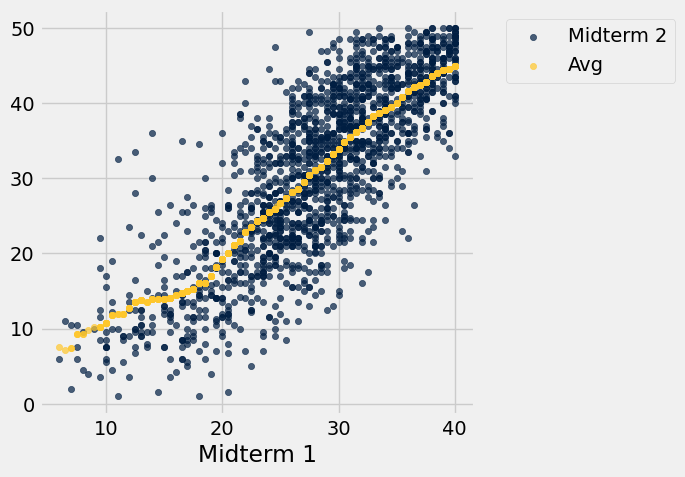

In [33]:
scores.drop(2).with_column('Avg', mt2_avg).scatter('Midterm 1')

# Tutoring

In [39]:
scores.sample(5)

Midterm 1,Midterm 2,Mentored
30.5,35,False
32,24.5,False
32.5,45,False
18,12.5,True
27.5,39.5,False


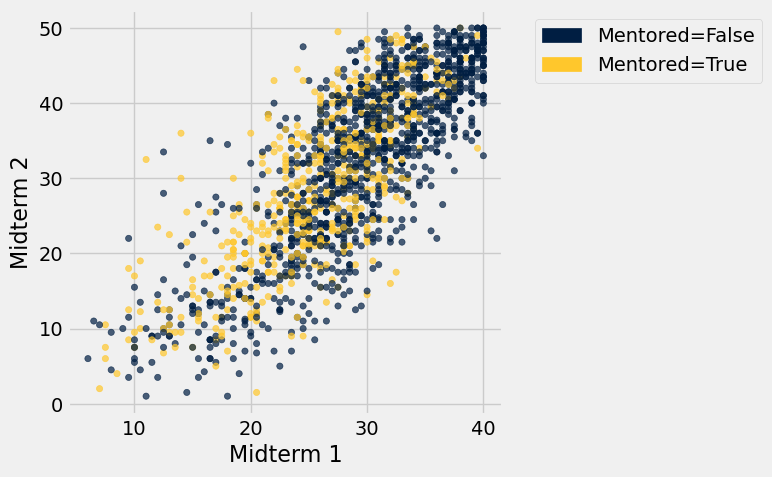

In [40]:
scores.scatter('Midterm 1', 'Midterm 2', group='Mentored')

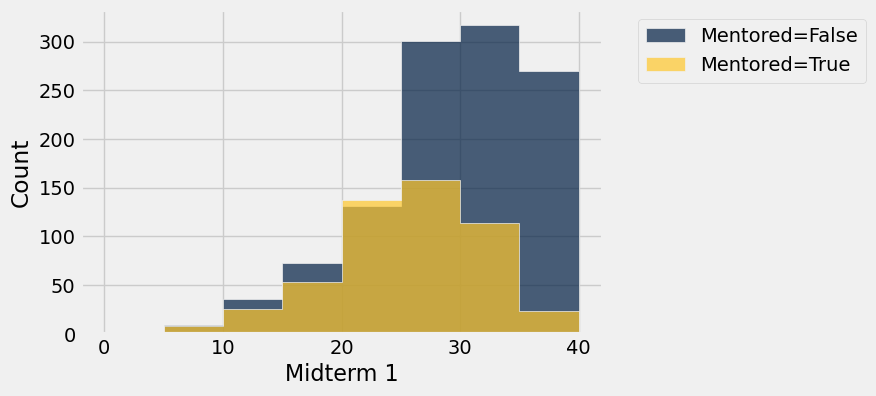

In [43]:
scores.hist('Midterm 1', group='Mentored', bins=np.arange(0, 41, 5), normed=False)
# mentored students tended to do worse

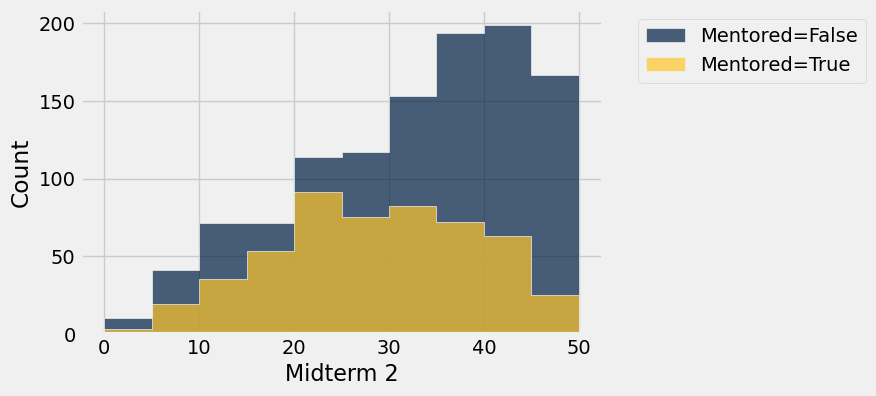

In [44]:
scores.hist('Midterm 2', group='Mentored', bins=np.arange(0, 51, 5), normed=False)
# a different distribution for sure! Unclear whether/by how much mentored students improved

In [45]:
# let's use nearest neighbors to predict the Midterm 2 score from the Midterm 1 score
# using un-mentored student data
no_mentor = scores.where("Mentored", False)

def avg_mt2_no_mentor(mt1):
    near = no_mentor.where("Midterm 1", are.between_or_equal_to(mt1-2, mt1+2))
    return near.column("Midterm 2").mean()

predicted_mt2 = scores.apply(avg_mt2_no_mentor, "Midterm 1")
# given a Midterm 1 score, we're predicting how well an un-mentored student will do on Midterm 2

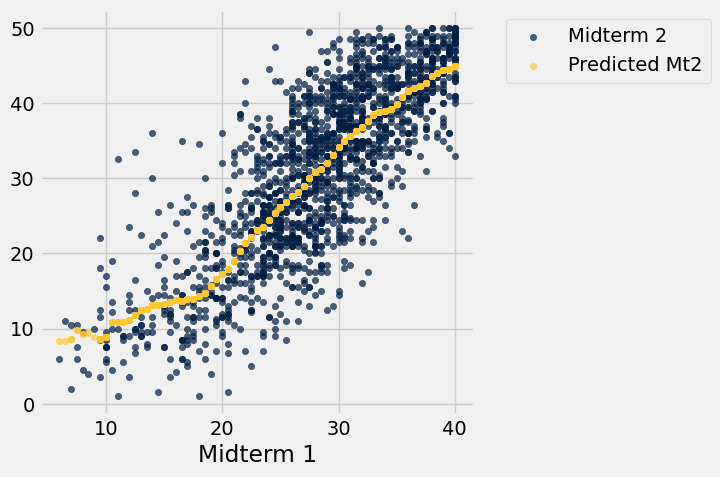

In [46]:
scores.drop(2).with_column('Predicted Mt2', predicted_mt2).scatter('Midterm 1')
# for mentored students, did their scores beat our prediction?
# that would imply that the mentoring helped!

In [48]:
scores = scores.with_column("Improvement", scores.column('Midterm 2') - predicted_mt2)
scores

Midterm 1,Midterm 2,Mentored,Improvement
28,20,False,-10.7918
28.5,35,False,3.74237
23.5,13.5,False,-9.97483
24.5,22.5,True,-2.83207
28.5,35.5,True,4.24237
22.5,28,True,5.872
24,22.5,False,-1.97254
29,36,True,3.98154
19.5,20,False,3.45588
19.5,20,True,3.45588


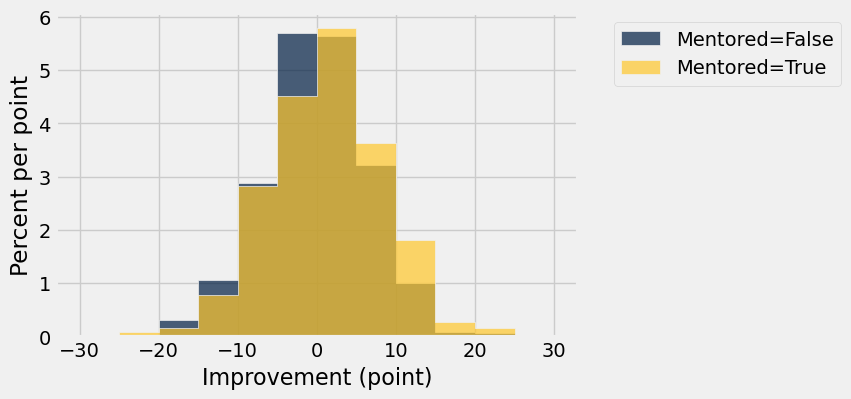

In [49]:
scores.hist("Improvement", bins=np.arange(-30, 31, 5), group="Mentored", unit="point")
# relatively, it looks like there are more mentored students in the positive bins!

In [53]:
# for mentored and un-mentored students, what how many of them had an "improvement" of at least 5 points?
# that is, they beat our prediction by at least 5 points

def of_at_least_5(values):
    return sum(values >= 5) / len(values)

scores.select('Mentored', 'Improvement').group('Mentored', of_at_least_5).set_format(1, PercentFormatter)

Mentored,Improvement of_at_least_5
False,21.90%
True,29.34%


In [54]:
scores.group("Mentored", np.mean)
# it looks like mentoring did something!
# new question: are the trends we're seeing just noise? Let's calculate a confidence interval!

Mentored,Midterm 1 mean,Midterm 2 mean,Improvement mean
False,29.3461,32.2821,-0.0226162
True,25.4551,28.3885,1.44288


In [59]:
# let's generate a 95% confidence interval for the mean improvement
def mean_ci(observations):
    means = make_array()
    for i in np.arange(2000):
        means = np.append(means, observations.sample().column("Improvement").mean())
    lower = percentile(2.5, means)
    upper = percentile(97.5, means)
    print("Mean improvement:", observations.column("Improvement").mean())
    print("95% CI of mean improvement:", lower, "to", upper)

# let's generate the confidence interval for mentored students only
mentored = scores.where("Mentored", True)
mean_ci(mentored)
# conclusion: we're very confident that they beat our prediction! Mentoring worked!

Mean improvement: 1.44287751219
95% CI of mean improvement: 0.818098233414 to 2.03129452468


In [60]:
mean_ci(mentored.where("Midterm 1", are.below(20)))
# students who performed extra poorly on the first midterm showed the best improvement

Mean improvement: 2.50099926463
95% CI of mean improvement: 1.17255615475 to 3.89000787987


In [61]:
mean_ci(mentored.where("Midterm 1", are.between(20, 30)))

Mean improvement: 1.70156625307
95% CI of mean improvement: 0.875290446389 to 2.4834650215


In [62]:
mean_ci(mentored.where("Midterm 1", are.above_or_equal_to(30)))
# mentoring may or may not have actually done anything for the students who did well on Midterm 1

Mean improvement: 0.221624597815
95% CI of mean improvement: -0.945890740041 to 1.29410832339
